# ***Teste Técnico - Programa Trainee triggo.ai de Excelência em Engenharia de Dados e DataOps 2025***

# **1. Preparação dos Dados**

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import kagglehub
import plotly.express as px
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brazilian-ecommerce


In [54]:
# Lista os arquivos disponíveis no diretório baixado
files = os.listdir(path)
print("Arquivos disponíveis:", files)

Arquivos disponíveis: ['olist_customers_dataset.csv', 'olist_sellers_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_order_items_dataset.csv', 'olist_products_dataset.csv', 'olist_geolocation_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_payments_dataset.csv']


In [55]:
# Carrega os arquivos CSV em um dicionário de DataFrames
dataframes = {}
for file in files:
    df_name = file.replace('.csv', '')
    df_path = os.path.join(path, file)
    dataframes[df_name] = pd.read_csv(df_path)

In [56]:
# Função para limpar um DataFrame
def limpar_df(df, nome):
    print(f"\n--- Limpando {nome} ---")
    linhas_antes = df.shape[0]

    # Remove duplicatas
    df = df.drop_duplicates()
    linhas_depois = df.shape[0]
    print(f"Removidas {linhas_antes - linhas_depois} duplicatas.")

    # Verifica valores nulos
    nulos = df.isnull().sum()
    print("Valores nulos por coluna:\n", nulos[nulos > 0])

    # Remove linhas com nulos
    df = df.dropna()
    print(f"Total de linhas após remoção de nulos: {df.shape[0]}")

    return df

# Aplica a limpeza para cada DataFrame
dataframes_limpos = {}
for nome, df in dataframes.items():
    df_limpo = limpar_df(df, nome)
    dataframes_limpos[nome] = df_limpo


--- Limpando olist_customers_dataset ---
Removidas 0 duplicatas.
Valores nulos por coluna:
 Series([], dtype: int64)
Total de linhas após remoção de nulos: 99441

--- Limpando olist_sellers_dataset ---
Removidas 0 duplicatas.
Valores nulos por coluna:
 Series([], dtype: int64)
Total de linhas após remoção de nulos: 3095

--- Limpando olist_order_reviews_dataset ---
Removidas 0 duplicatas.
Valores nulos por coluna:
 review_comment_title      87656
review_comment_message    58247
dtype: int64
Total de linhas após remoção de nulos: 9839

--- Limpando olist_order_items_dataset ---
Removidas 0 duplicatas.
Valores nulos por coluna:
 Series([], dtype: int64)
Total de linhas após remoção de nulos: 112650

--- Limpando olist_products_dataset ---
Removidas 0 duplicatas.
Valores nulos por coluna:
 product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm              

In [57]:
# Criação do modelo relacional
# Tabelas principais
orders = dataframes_limpos['olist_orders_dataset']
order_items = dataframes_limpos['olist_order_items_dataset']
customers = dataframes_limpos['olist_customers_dataset']
products = dataframes_limpos['olist_products_dataset']
sellers = dataframes_limpos['olist_sellers_dataset']
payments = dataframes_limpos['olist_order_payments_dataset']
reviews = dataframes_limpos['olist_order_reviews_dataset']
geolocation = dataframes_limpos['olist_geolocation_dataset']
category_translation = dataframes_limpos['product_category_name_translation']

# Relaciona customers com orders
orders_customers = orders.merge(customers, on='customer_id', how='left')

# Relaciona orders com order_items
orders_full = orders_customers.merge(order_items, on='order_id', how='left')

# Relaciona com produtos
orders_full = orders_full.merge(products, on='product_id', how='left')

# Relaciona com vendedores
orders_full = orders_full.merge(sellers, on='seller_id', how='left')

# Relaciona com pagamentos
orders_full = orders_full.merge(payments, on='order_id', how='left')

# Relaciona com avaliações
orders_full = orders_full.merge(reviews, on='order_id', how='left')

# Relaciona com nome traduzido da categoria de produto
orders_full = orders_full.merge(category_translation, on='product_category_name', how='left')

# Resultado final
print("Modelo relacional criado. Shape final:", orders_full.shape)

Modelo relacional criado. Shape final: (115033, 40)


A preparação dos dados foi inciada por meio do download dos arquivos do dataset da Olist, que foram posteriormente carregados em um dicionário de DataFrames. Em seguida, foi aplicada uma função de limpeza para cada DataFrame, que removeu duplicatas e eliminou todas as linhas que continham valores nulos. Após essa limpeza, iniciou-se a construção do modelo relacional entre as tabelas principais: os dados de pedidos foram conectados aos de clientes, itens do pedido, produtos, vendedores, pagamentos e avaliações, utilizando chaves primárias e estrangeiras apropriadas para posterior análise.

# **2. Análise Exploratória de Dados**

## a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

In [58]:
# Garante que a coluna de data está no formato datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Cria coluna de ano-mês
orders['ano_mes'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Agrupa por ano e mês e contar pedidos
pedidos_por_mes = orders.groupby('ano_mes')['order_id'].count().reset_index()
pedidos_por_mes.columns = ['ano_mes', 'volume_pedidos']

# Exibe resultado
print(pedidos_por_mes.to_string(index=False))

ano_mes  volume_pedidos
2016-09               1
2016-10             270
2016-12               1
2017-01             748
2017-02            1641
2017-03            2546
2017-04            2303
2017-05            3545
2017-06            3135
2017-07            3872
2017-08            4193
2017-09            4149
2017-10            4478
2017-11            7288
2017-12            5513
2018-01            7069
2018-02            6556
2018-03            7003
2018-04            6798
2018-05            6749
2018-06            6096
2018-07            6156
2018-08            6351


In [59]:
# Remove meses com menos de 100 pedidos
limiar = 100
pedidos_validos = pedidos_por_mes[pedidos_por_mes['volume_pedidos'] >= limiar].copy()

# Média geral de pedidos por mês (após remoção)
media_geral = pedidos_validos['volume_pedidos'].mean()
print(f"Média geral de pedidos por mês (excluindo meses com menos de {limiar} pedidos): {media_geral:.2f}")

# Adiciona coluna com apenas o mês (ex: '01' para janeiro)
pedidos_validos['mes'] = pedidos_validos['ano_mes'].dt.month

# Calcula média de pedidos por mês (considerando todos os anos)
media_por_mes = pedidos_validos.groupby('mes')['volume_pedidos'].mean().reset_index()
media_por_mes.columns = ['mes', 'media_pedidos']
print("\nMédia de pedidos por mês:")
print(media_por_mes.to_string(index=False))

Média geral de pedidos por mês (excluindo meses com menos de 100 pedidos): 4593.29

Média de pedidos por mês:
 mes  media_pedidos
   1         3908.5
   2         4098.5
   3         4774.5
   4         4550.5
   5         5147.0
   6         4615.5
   7         5014.0
   8         5272.0
   9         4149.0
  10         2374.0
  11         7288.0
  12         5513.0


O volume médio de pedidos por mês é de 4593.29. Além disso, observa-se sazonalidade nas vendas por meio do aumento expressivo no número de pedidos em novembro, impulsionado principalmente pelas promoções da Black Friday, que representam o pico de vendas do ano. Em seguida, dezembro também apresenta um volume elevado, provavelmente devido às compras de Natal. Por outro lado, há quedas perceptíveis em outubro e setembro, meses que antecedem a Black Friday, e no início do ano, especialmente em janeiro, refletindo uma desaceleração típica do pós-festas.


## b) Qual a distribuição do tempo de entrega dos pedidos?

Estatísticas da distribuição do tempo de entrega (em dias):
count    96455.000000
mean        12.093100
std          9.551209
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: tempo_entrega, dtype: float64


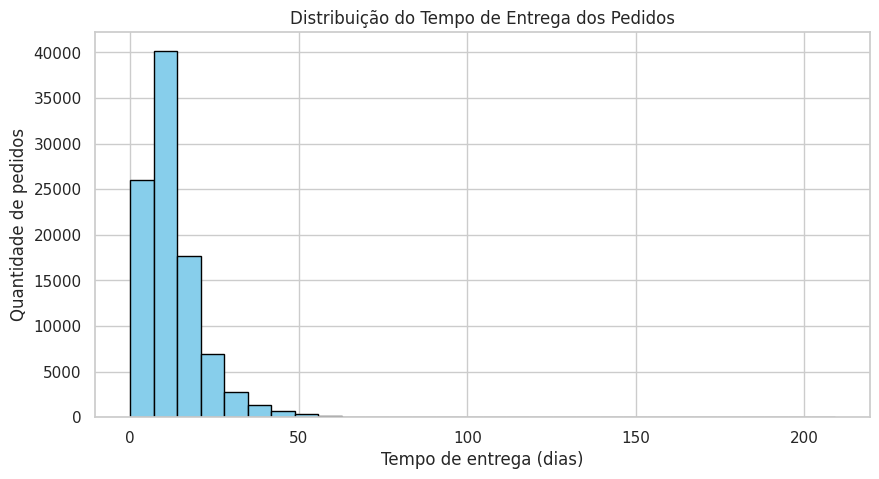

In [60]:
# Filtra pedidos entregues
pedidos_entregues = orders[orders['order_status'] == 'delivered'].copy()

# Converte colunas de data para datetime (se ainda não estiverem)
pedidos_entregues['order_purchase_timestamp'] = pd.to_datetime(pedidos_entregues['order_purchase_timestamp'])
pedidos_entregues['order_delivered_customer_date'] = pd.to_datetime(pedidos_entregues['order_delivered_customer_date'])

# Calcula tempo de entrega em dias
pedidos_entregues['tempo_entrega'] = (pedidos_entregues['order_delivered_customer_date'] - pedidos_entregues['order_purchase_timestamp']).dt.days

# Remove valores negativos ou inválidos (caso existam)
pedidos_entregues = pedidos_entregues[pedidos_entregues['tempo_entrega'] >= 0]

# Exibe estatísticas da distribuição
print("Estatísticas da distribuição do tempo de entrega (em dias):")
print(pedidos_entregues['tempo_entrega'].describe())

# Plota o histograma da distribuição
plt.figure(figsize=(10, 5))
plt.hist(pedidos_entregues['tempo_entrega'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição do Tempo de Entrega dos Pedidos')
plt.xlabel('Tempo de entrega (dias)')
plt.ylabel('Quantidade de pedidos')
plt.grid(True)
plt.show()

A distribuição do tempo de entrega dos pedidos revela que, em média, os consumidores receberam seus produtos em cerca de 12 dias após a compra. A maioria das entregas (50% dos casos) ocorreu em até 10 dias, com 75% sendo concluídas em até 15 dias. Apesar disso, há uma grande variabilidade nos prazos, com entregas que chegam no mesmo dia (mínimo de 0 dias) e casos extremos que levaram até 209 dias.

## c) Qual a relação entre o valor do frete e a distância de entrega?

Correlação entre distância e valor do frete: 0.39


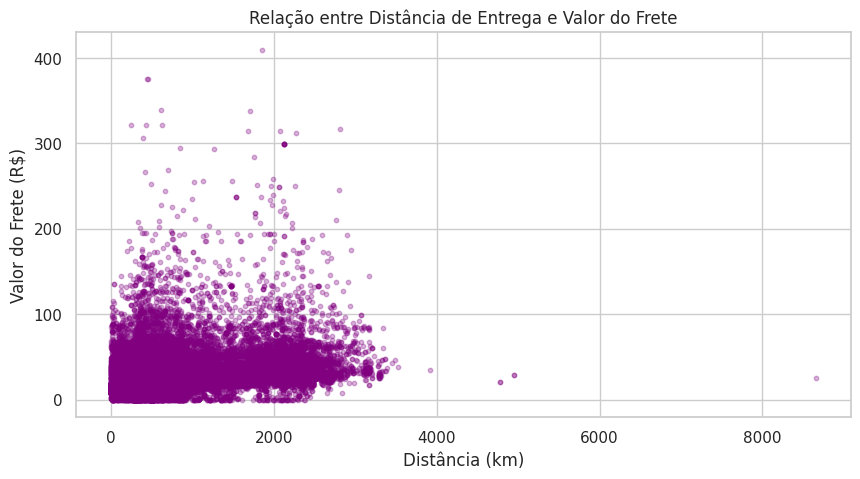

In [61]:
# Junta pedidos com dados de clientes e vendedores
df = orders.merge(order_items, on='order_id')
df = df.merge(customers, on='customer_id')
df = df.merge(sellers, on='seller_id')
df = df.merge(payments, on='order_id')

# Seleciona a geolocalização média para cada zip prefix
geo = geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
geo.columns = ['zip_code_prefix', 'lat', 'lng']

# Junta localização do cliente
df = df.merge(geo, left_on='customer_zip_code_prefix', right_on='zip_code_prefix', how='left')
df.rename(columns={'lat': 'customer_lat', 'lng': 'customer_lng'}, inplace=True)
df.drop(columns=['zip_code_prefix'], inplace=True)

# Junta localização do vendedor
df = df.merge(geo, left_on='seller_zip_code_prefix', right_on='zip_code_prefix', how='left')
df.rename(columns={'lat': 'seller_lat', 'lng': 'seller_lng'}, inplace=True)
df.drop(columns=['zip_code_prefix'], inplace=True)

# Calcula a distância entre cliente e vendedor
def calcular_distancia(row):
    try:
        origem = (row['seller_lat'], row['seller_lng'])
        destino = (row['customer_lat'], row['customer_lng'])
        return geodesic(origem, destino).km
    except:
        return None

df['distancia_km'] = df.apply(calcular_distancia, axis=1)

# Remove linhas com distância ou frete nulo
df = df.dropna(subset=['distancia_km', 'freight_value'])

# Correlação
correlacao = df['freight_value'].corr(df['distancia_km'])
print(f"Correlação entre distância e valor do frete: {correlacao:.2f}")

# Gráfico de dispersão
plt.figure(figsize=(10, 5))
plt.scatter(df['distancia_km'], df['freight_value'], alpha=0.3, s=10, color='purple')
plt.title('Relação entre Distância de Entrega e Valor do Frete')
plt.xlabel('Distância (km)')
plt.ylabel('Valor do Frete (R$)')
plt.grid(True)
plt.show()

A relação entre o valor do frete e a distância de entrega apresenta uma correlação positiva moderada de 0,39, indicando que, em geral, quanto maior a distância entre o vendedor e o cliente, maior tende a ser o custo do frete. No entanto, o valor do frete não depende apenas da distância, pois a correlação não é muito alta, o que sugere que outros fatores, como peso do produto, volume, tipo de transporte e políticas comerciais, também influenciam significativamente o preço cobrado. Essa dispersão pode ser observada na distribuição dos dados, onde pedidos com distâncias semelhantes apresentam valores de frete bastante variados.

## d) Quais são as categorias de produtos mais vendidas em termos de faturamento?

In [62]:
orders_full['faturamento_item'] = orders_full['price']  # assumindo 1 unidade por item

# Soma faturamento por categoria traduzida
faturamento_categoria = orders_full.groupby('product_category_name_english')['faturamento_item'].sum().reset_index()

# Ordena por faturamento decrescente
faturamento_categoria = faturamento_categoria.sort_values(by='faturamento_item', ascending=False)

# Mostra as top 10 categorias
print(faturamento_categoria.head(10).to_string(index=False))

product_category_name_english  faturamento_item
                health_beauty        1271548.15
                watches_gifts        1213452.70
               bed_bath_table        1077834.14
               sports_leisure         990454.67
        computers_accessories         918837.87
              furniture_decor         745748.80
                   housewares         648187.74
                   cool_stuff         634163.78
                         auto         602881.75
                 garden_tools         492255.08


As categorias de produtos que mais se destacam em termos de faturamento são "health\_beauty" (saúde e beleza), "watches\_gifts" (relógios e presentes) e "bed\_bath\_table" (cama, banho e mesa), liderando as vendas com receitas superiores a um milhão de reais cada. Essas categorias representam segmentos com alta demanda e/ou produtos com maior valor agregado, o que resulta no maior faturamento total.

## e) Quais estados brasileiros possuem o maior valor médio de pedido?

In [63]:
# Agrupa por estado do cliente e calcula o valor médio do pedido
valor_medio_por_estado = orders_full.groupby('customer_state')['price'].mean().reset_index()

# Ordena do maior para o menor
valor_medio_por_estado = valor_medio_por_estado.sort_values(by='price', ascending=False)

# Renomeia colunas para melhor entendimento
valor_medio_por_estado.columns = ['Estado', 'Valor Médio do Pedido']

# Mostra os top 10 estados
print(valor_medio_por_estado.head(10).to_string(index=False))

Estado  Valor Médio do Pedido
    PB             194.293868
    AL             185.150272
    AC             180.930426
    RN             166.889893
    RO             165.502313
    PA             165.074000
    TO             164.768503
    AP             163.310964
    PI             162.549060
    CE             154.766969


Os estados brasileiros com o maior valor médio de pedido no e-commerce são, surpreendentemente, principalmente do Norte e Nordeste do país, como Paraíba (PB), Alagoas (AL), Acre (AC), Rio Grande do Norte (RN) e Rondônia (RO). Esses estados apresentam valores médios de pedido acima de R\$160, indicando que, embora tenham menor volume total de vendas, os consumidores tendem a realizar compras com ticket médio mais alto. Provavelmente, esse maior valor médio se deve ao custo elevado do frete nessas regiões, o que eleva o preço final dos pedidos. Esse fenômeno evidencia como fatores logísticos influenciam diretamente o comportamento de compra e o faturamento do e-commerce nas diferentes regiões do Brasil.

# **3. Solução de Problemas de Negócio**

## 1. Análise de Retenção

In [64]:
# Contagem de pedidos por cliente
pedidos_por_cliente = orders_full.groupby('customer_unique_id')['order_id'].nunique().reset_index()
pedidos_por_cliente.columns = ['customer_unique_id', 'num_pedidos']

# Classifica clientes recorrentes
clientes_recorrentes = pedidos_por_cliente[pedidos_por_cliente['num_pedidos'] > 1]
clientes_unicos_total = pedidos_por_cliente.shape[0]

# Calcula taxa de clientes recorrentes
taxa_recorrencia = len(clientes_recorrentes) / clientes_unicos_total
print(f"Taxa de clientes recorrentes: {taxa_recorrencia:.2%}")

Taxa de clientes recorrentes: 3.00%


A taxa de clientes recorrentes no período analisado foi de apenas 3%, o que indica que 97% dos clientes compraram apenas uma vez na plataforma. Esse número evidencia uma baixa retenção de consumidores, o que representa uma oportunidade significativa de melhoria: investir em estratégias de fidelização — como programas de recompensas, e-mails personalizados, descontos para segunda compra e acompanhamento pós-venda — pode aumentar substancialmente o valor de cada cliente ao longo do tempo.


## 2. Predição de Atraso

Um pedido será considerado atrasado se a data de entrega ao cliente for posterior à data estimada de entrega (*order_delivered_customer_date* > *order_estimated_delivery_date*)

In [65]:
# Filtra pedidos com datas completas
df_entregas = orders_full.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])

# Cria variável binária de atraso
df_entregas['atrasado'] = (df_entregas['order_delivered_customer_date'] > df_entregas['order_estimated_delivery_date']).astype(int)

In [66]:
# Conversão para datetime
df_entregas['order_delivered_customer_date'] = pd.to_datetime(df_entregas['order_delivered_customer_date'])
df_entregas['order_purchase_timestamp'] = pd.to_datetime(df_entregas['order_purchase_timestamp'])

# Cria as features
df_entregas['tempo_envio_dias'] = (df_entregas['order_delivered_customer_date'] - df_entregas['order_purchase_timestamp']).dt.days
df_entregas['quantidade_itens'] = df_entregas.groupby('order_id')['order_item_id'].transform('count')
df_entregas['valor_total'] = df_entregas['price'] + df_entregas['freight_value']

# Seleciona colunas finais para o modelo
features = df_entregas[['tempo_envio_dias', 'freight_value', 'valor_total', 'quantidade_itens']]
target = df_entregas['atrasado']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Treinamento
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)

# Avaliação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     21184
           1       0.77      0.69      0.73      1823

    accuracy                           0.96     23007
   macro avg       0.87      0.84      0.85     23007
weighted avg       0.96      0.96      0.96     23007



O modelo de predição de atraso apresentou um bom desempenho geral, com 96% de acurácia. Para os pedidos entregues no prazo (classe 0), o modelo teve excelente precisão (97%) e recall (98%), indicando que ele identifica corretamente quase todos os pedidos pontuais. No entanto, seu desempenho para prever atrasos (classe 1) foi mais modesto, com precisão de 77% e recall de 69%. Isso significa que ele consegue identificar corretamente a maioria dos pedidos atrasados, mas ainda deixa passar uma parte deles. A diferença de desempenho entre as classes se deve, em parte, ao desbalanceamento dos dados (há muito mais pedidos entregues no prazo do que com atraso).

## 3. Segmentação de Clientes

In [67]:
# Agrupa por cliente
clientes = df_entregas.groupby('customer_unique_id').agg(
    frequencia=('order_id', 'nunique'),
    valor_total=('price', 'sum'),
    ticket_medio=('price', 'mean'),
    primeira_compra=('order_purchase_timestamp', 'min'),
    ultima_compra=('order_purchase_timestamp', 'max')
).reset_index()

# Converte datas
clientes['primeira_compra'] = pd.to_datetime(clientes['primeira_compra'])
clientes['ultima_compra'] = pd.to_datetime(clientes['ultima_compra'])

# Tempo médio entre compras (aproximação simples)
clientes['dias_entre_compras'] = (
    (clientes['ultima_compra'] - clientes['primeira_compra']).dt.days / (clientes['frequencia'] - 1)
).replace([np.inf, -np.inf], np.nan).fillna(0)

# Seleciona features e normalizar
features_cluster = clientes[['frequencia', 'valor_total', 'ticket_medio', 'dias_entre_compras']]
features_normalizadas = StandardScaler().fit_transform(features_cluster)

# Escolha do número de clusters (exemplo: 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clientes['cluster'] = kmeans.fit_predict(features_normalizadas)

# Perfil médio por cluster
perfil_clusters = clientes.groupby('cluster')[['frequencia', 'valor_total', 'ticket_medio', 'dias_entre_compras']].mean()
print(perfil_clusters)

         frequencia  valor_total  ticket_medio  dias_entre_compras
cluster                                                           
0          1.027375   511.396466    434.170178            0.242392
1          2.230044   279.197460    103.449983          155.611702
2          1.014381    96.745163     85.176926            0.107913
3          1.019036  1886.519391   1535.880475            0.340525


O Cluster 3 representa clientes de alto valor, com ticket médio elevado (R$1535,88) e valor total gasto mais alto, ainda que com baixa frequência — são clientes valiosos que fazem compras pontuais de alto valor, ideais para estratégias de luxo, produtos premium ou exclusividades.

O Cluster 0 é semelhante, com ticket médio alto, mas menor gasto total, podendo indicar compras grandes únicas — bom alvo para fidelização.

O Cluster 1 representa clientes recorrentes, com frequência média acima de 2 e ticket médio baixo (~R$103), sugerindo compradores frequentes de itens acessíveis — ideais para campanhas de fidelização, descontos progressivos e programas de pontos.

Já o Cluster 2 agrupa clientes com baixo engajamento (baixa frequência, baixo gasto total e ticket médio), sendo potenciais alvos para campanhas de reativação e descoberta de produtos.

## 4. Análise de Satisfação

In [68]:
# Seleciona colunas relevantes
avaliacoes = orders_full[[
    'review_score',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_purchase_timestamp',
    'product_category_name_english',
    'price',
    'freight_value'
]].dropna()

# Conversão para datetime
avaliacoes['order_purchase_timestamp'] = pd.to_datetime(avaliacoes['order_purchase_timestamp'])
avaliacoes['order_delivered_customer_date'] = pd.to_datetime(avaliacoes['order_delivered_customer_date'])
avaliacoes['order_estimated_delivery_date'] = pd.to_datetime(avaliacoes['order_estimated_delivery_date'])

# Tempo real de entrega
avaliacoes['tempo_entrega'] = (avaliacoes['order_delivered_customer_date'] - avaliacoes['order_purchase_timestamp']).dt.days

# Atraso em relação à estimativa
avaliacoes['dias_atraso'] = (avaliacoes['order_delivered_customer_date'] - avaliacoes['order_estimated_delivery_date']).dt.days
avaliacoes['dias_atraso'] = avaliacoes['dias_atraso'].apply(lambda x: x if x > 0 else 0)  # ignora entregas no prazo

# Valor total
avaliacoes['valor_total'] = avaliacoes['price'] + avaliacoes['freight_value']
correlacoes = avaliacoes[['review_score', 'tempo_entrega', 'dias_atraso', 'price', 'freight_value', 'valor_total']].corr()
print(correlacoes['review_score'].sort_values(ascending=False))

review_score     1.000000
price           -0.018493
valor_total     -0.020351
freight_value   -0.030055
dias_atraso     -0.218882
tempo_entrega   -0.245927
Name: review_score, dtype: float64


O fator com maior impacto negativo na satisfação é o tempo total de entrega, seguido pelos atrasos, ou seja, melhorar a eficiência logística e garantir entregas no prazo são as ações mais eficazes para aumentar a satisfação do cliente. Por outro lado, preço e frete têm influência muito pequena ou quase nula sobre a avaliação do cliente e, dessa forma, reduzir esses indicadores não é tão impactante.

# **4. Visualização e Dashboards**

## 2. Mapa de calor mostrando a concentração de vendas por região/estado do Brasil


In [69]:
# Agrupa a quantidade de pedidos por estado
vendas_por_estado = orders_full.groupby('customer_state')['order_id'].nunique().reset_index()
vendas_por_estado.columns = ['Estado', 'Quantidade de Pedidos']

# Mapa de calor
fig = px.choropleth(
    vendas_por_estado,
    geojson='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson',
    featureidkey='properties.sigla',
    locations='Estado',
    color='Quantidade de Pedidos',
    color_continuous_scale='YlOrRd',
    scope='south america',
    labels={'Quantidade de Pedidos': 'Pedidos'},
    title='Concentração de Vendas por Estado no Brasil'
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()